In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 4-connected (i.e. only moves into cardinal directions are allowed)
        '''   
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]] 
        diag_delta = [[1, 1], [1, -1], [-1, -1], [-1,1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        for d in diag_delta:
            if (self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) 
                and (i + d[0], j) in neighbors and (i, j + d[1]) in neighbors):
                neighbors.append((i + d[0], j + d[1]))
#                 print(neighbors)
        return neighbors

    def get_size(self):
        return (self._height, self._width)


Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if the connectivity of a grid exceeds 4 the cost of a transition may vary.

Recall that in this lab we assume 4-connected grid, i.e. only cardinal moves are allowed.

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) in [1, 2]:
        return np.sqrt(abs(i1 - i2) + abs(j1 - j2))
    else:
        raise Exception('Trying to compute the cost of non-supported move! ONLY cardinal moves are supported.')

### Search Node

Search node is the core concept for any (heuristic) search algorithm. It ties together and encapsulates data both about the state of the problem at hand (in the considered case state = the position of the robot/agent on a grid) and data needed to conduct the search (g-, h, f-values etc.)


In [4]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent
        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return  self.f < other.f

### Visualization

In [5]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 5
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


### Validating the results


In [6]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length


`simple_test` tests the pathfing algorithm on a single simple instance. Tests assume that the search function fits the following pattern:


`search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, nodes_created, discovered, expanded)`, where

- `task_map` -- grid
- `start.i, start.j` -- (i,j) coordinates of the start cell
- `goal.i, goal.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`. E.g. the heuristic function.
- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `steps` -- the number of search steps
- `nodes_created` -- the number of the nodes, which were created and stored during the search process 
- `open` -- iterable collection of open nodes
- `expanded` --  iterable collection of the expanded nodes
- `re-expanded` -- iterable collection of the re-expanded nodes

In [7]:
def read_map_from_file(path):
    '''
    Reads map
    '''

    tasks_file = open(path)
    someline = tasks_file.readline()
    height = int(tasks_file.readline().split()[1])
    width = int(tasks_file.readline().split()[1])
    someline = tasks_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0


    for l in tasks_file:
        j = 0
        for c in l:
            if c in ['.', "W", "T", "S"]:
                cells[i][j] = 0
            elif c in ['#', "@"]:
                cells[i][j] = 1
            else:
                continue
            j += 1
                
        i += 1
        if(i == height):
            break
            
    return (width, height, cells)

import numpy as np

def read_task_from_file(path, task_num):
    '''
    Reads start/goal positions and true value of path length between given start and goal from file by path. 
    '''
    
    tasks_file = open(path)
    
    data = tasks_file.read()
    lines = data.split('\n')
    line_choice = np.random.randint(1, len(lines), size=task_num)
    starts_i, starts_j, goals_i, goals_j, lengths = [], [], [], [], []
    for l in line_choice:
        line = lines[l]
        level, task_name, height, width, start_i, start_j, goal_i, goal_j, length = line.split()
        starts_i.append(int(start_i))
        starts_j.append(int(start_j))
        goals_i.append(int(goal_i))
        goals_j.append(int(goal_j))
        lengths.append(float(length))
    
    return (starts_i, starts_j, goals_i, goals_j, lengths)


In [8]:
# read_task_from_file("data/1.scen", 10)

In [9]:
from time import time 

def massive_test(search_func, data_path, num_of_tasks=None, *args):
    '''
    massive_test runs search_func on set of differnt tasks (from directory data/) 
    with *args as optional arguments and 
    for every task displays the short report:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    the function also returns a dictionary with statistics. 
    It contains the next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["hardness_expansions"] = []
    stat["hardness_length_per_heuristic"] = []
    stat["steps"] = []
    stat["Problems_precentage"] = []
    stat["error"] = []
    stat["memory"] = []
    stat["runtime"] = []

    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    for task_count in range(1, 6):   
        problems = 0
        map_file_name = data_path + str(task_count) + ".map"
        task_file_name = data_path + str(task_count) + ".scen"
        print(f"Map: {task_count}")
        task_map.set_grid_cells(*read_map_from_file(map_file_name))
        starts_j, starts_i, goals_j, goals_i, lengths = read_task_from_file(task_file_name, task_num)
        
        for i in range(task_num):
            start_i, start_j, goal_i, goal_j, length = starts_i[i], starts_j[i], goals_i[i], goals_j[i], lengths[i]
            try:
                t1 = time()
                result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
                t2 = time()
                number_of_steps = result[2]
                nodes_created = result[3]
                if result[0]:
                    stat["runtime"].append(t2 - t1)
                    stat["hardness_expansions"].append(nodes_created)
                    stat["hardness_length_per_heuristic"].append(length / euclid_distance(start_i, start_j, goal_i, goal_j))
                    stat["steps"].append(number_of_steps) 
                    stat["memory"].append(len(result[4]) + len(result[5]))
                    path = make_path(result[1]) 
                    stat["error"].append(abs(path[1] - length))
                    correct = abs(path[1] - length) < 1e-3
                    stat["corr"].append(correct)
                    if not correct:
                        problems += 1
                else:
                    print("Path not found!")
                    stat["corr"].append(False)
                    problems += 1

            except Exception as e:
                print("Execution error")
                print(e)
                problems += 1
        stat["Problems_precentage"].append(problems / task_num)
    stat["Problems"] = problems
    return stat

In [10]:
def call_test(search_func, data_path, nuber_of_file,number_of_task=None, *args):
    map_file_name = data_path + str(nuber_of_file) + ".map"
    task_file_name = data_path + str(nuber_of_file) + ".scen"
    task_map = Map()
    
    task_map.set_grid_cells(*read_map_from_file(map_file_name))
    
    starts_j, starts_i, goals_j, goals_i, lengths = read_task_from_file(task_file_name, number_of_task + 1)
    start_i, start_j, goal_i, goal_j, length = starts_i[number_of_task], starts_j[number_of_task], goals_i[number_of_task], goals_j[number_of_task], lengths[number_of_task]
    try:
        result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = make_path(result[1]) 
            correct = abs(path[1] - length) < 1e-3 #int(path[1])  == int(length)
            if not correct:
                print(f"error in {nuber_of_file}")
                print("Length_our: " + str(path[1]) + "  length_true:" + str(length))
                draw(task_map, path[0][0], path[0][-1], path[0], *result[4:])
        else:
            print("Path not found!")
            print(f"error in {nuber_of_file}")

    except Exception as e:
        print("Execution error")
        print(e)

## A* Algorithm (without re-expansions)

In [11]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    Modified Dijkstra algorithm for monotonous heuristics
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        
        if (best == goal):
            return True, best_node, steps, nodes_created, ast.OPEN, ast.CLOSED
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + compute_cost(*best, *succ), heuristic_func(*succ, *goal), parent=best_node)
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)
    return False, None, steps, nodes_created, ast.OPEN, ast.CLOSED


In [12]:
class SearchTreePQS: #Non list-based implementation of the search tree
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = set()       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
    
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [13]:
def manhattan_distance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

def euclid_distance(i1, j1, i2, j2):
    return np.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

def octile_distance(i1, j1, i2, j2):
    return (np.sqrt(2) * min(abs(i1 - i2), abs(j1 - j2)) + 
            (max(abs(i1 - i2), abs(j1 - j2)) - min(abs(i1 - i2), abs(j1 - j2))))

def chebyshev_distance(i1, j1, i2, j2):
    return max(abs(i1 - i2), abs(j1 - j2))

In [14]:
n = 100

In [17]:
%time res_eu = a_star_stat = massive_test(astar, "data/", n, euclid_distance, SearchTreePQS)

Map: 1
Map: 2
Map: 3
Map: 4
Map: 5
CPU times: total: 35min 26s
Wall time: 35min 29s


In [19]:
np.mean(res_eu["steps"]), np.mean(res_eu["hardness_expansions"])

(64974.826, 490840.192)

In [20]:
%time res_cheb = a_star_stat = massive_test(astar, "data/", n, chebyshev_distance, SearchTreePQS)

Map: 1
Map: 2
Map: 3
Map: 4
Map: 5
CPU times: total: 36min 9s
Wall time: 36min 10s


In [31]:
%time res_diag = a_star_stat = massive_test(astar, "data/", n, octile_distance, SearchTreePQS)

Map: 1
Map: 2
Map: 3
Map: 4
Map: 5
CPU times: total: 31min 39s
Wall time: 31min 49s


In [32]:
%time res_mnh = a_star_stat = massive_test(astar, "data/", n, manhattan_distance, SearchTreePQS)

Map: 1
Map: 2
Map: 3
Map: 4
Map: 5
CPU times: total: 24min 41s
Wall time: 24min 45s


In [33]:
import seaborn as  sns
import pandas as pd

df = pd.DataFrame([[i,r] for i, r in zip(["euclid"] * len(res_eu["hardness_expansions"]) + ["chebushev"] * len(res_cheb["hardness_expansions"]) + ["diagonal"] * len(res_diag["hardness_expansions"]) + ["manhatan"] * len(res_mnh["hardness_expansions"]),
                                          res_eu["hardness_expansions"] + res_cheb["hardness_expansions"] + res_diag["hardness_expansions"] + res_mnh["hardness_expansions"])])

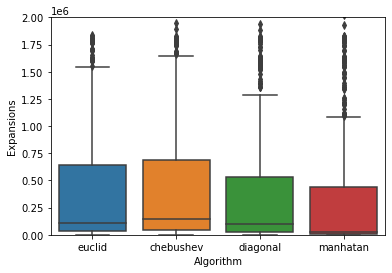

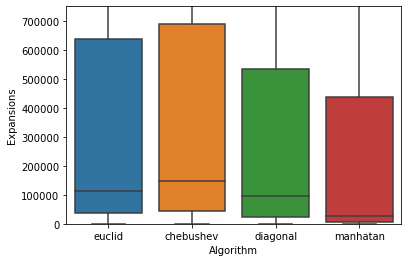

In [40]:
s = sns.boxplot(x=df[0], y=df[1], orient="v")
s.set(xlabel='Algorithm', ylabel='Expansions')
plt.ylim(0,2e6)
plt.show()

s = sns.boxplot(x=df[0], y=df[1], orient="v")
s.set(xlabel='Algorithm', ylabel='Expansions')
plt.ylim(0,.75e6)
plt.show()

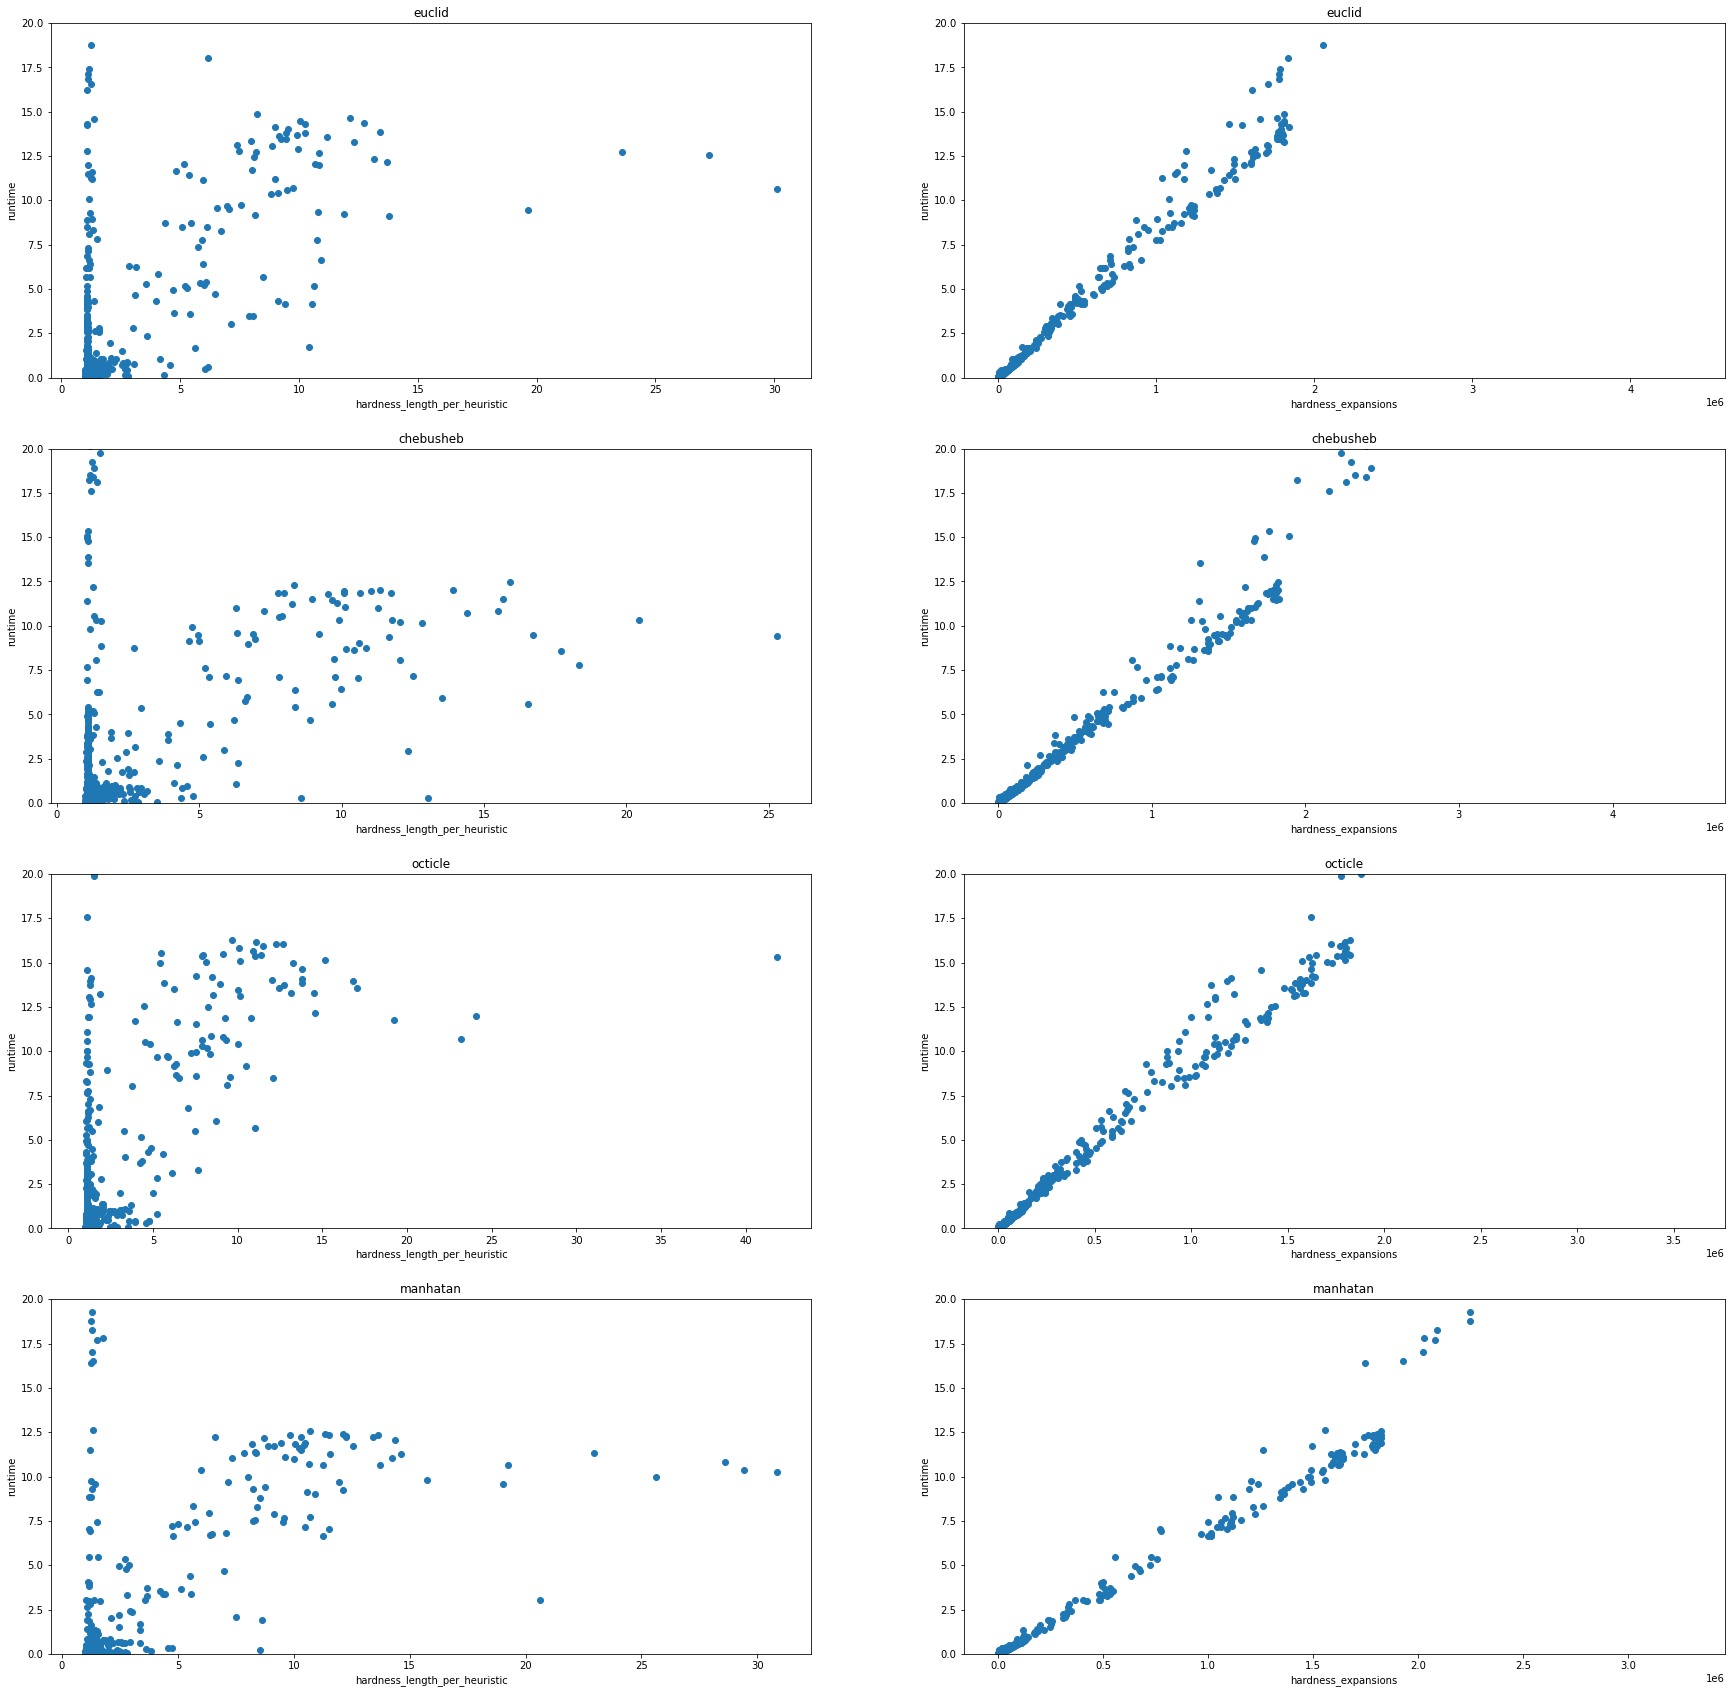

In [66]:
figure, axis = plt.subplots(4, 2, figsize=(30, 30))

for i, res, res_name in zip(range(4), [res_eu, res_cheb, res_diag, res_mnh], ["euclid", "chebusheb", "octicle", "manhatan"]):
    for j, name in zip(range(2), ["hardness_length_per_heuristic", "hardness_expansions"]):
        axis[i,j].scatter(y=res["runtime"], x=res[name])
        axis[i,j].set(title=res_name)
        axis[i,j].set(xlabel=name)
        axis[i,j].set(ylabel="runtime")
        axis[i,j].set(ylim=(0,20))

In [46]:
for res, name in zip([res_eu, res_cheb, res_diag, res_mnh], ["euclid", "chebusheb", "octicle", "manhatan"]):    
    print(f"Heuristic: {name}")
    for num_of_map in range(5):
        print(f"Map {num_of_map + 1}:  Problems_percentage: {res['Problems_precentage'][num_of_map]}")

Heuristic: euclid
Map 1:  Problems_percentage: 0.0
Map 2:  Problems_percentage: 0.0
Map 3:  Problems_percentage: 0.0
Map 4:  Problems_percentage: 0.0
Map 5:  Problems_percentage: 0.0
Heuristic: chebusheb
Map 1:  Problems_percentage: 0.0
Map 2:  Problems_percentage: 0.0
Map 3:  Problems_percentage: 0.0
Map 4:  Problems_percentage: 0.0
Map 5:  Problems_percentage: 0.0
Heuristic: octicle
Map 1:  Problems_percentage: 0.0
Map 2:  Problems_percentage: 0.0
Map 3:  Problems_percentage: 0.0
Map 4:  Problems_percentage: 0.0
Map 5:  Problems_percentage: 0.0
Heuristic: manhatan
Map 1:  Problems_percentage: 0.0
Map 2:  Problems_percentage: 0.97
Map 3:  Problems_percentage: 0.24
Map 4:  Problems_percentage: 0.22
Map 5:  Problems_percentage: 0.22


В целом, мы видим, что время работы алгоритма примерно линейно зависит от количества раскрытий.
И несмотря на то, что адекватнее было бы нарисовать графики на для каждой карты, мы все равно можем заметить, что время работы алгоритма не сильно растет при росте отношения длины пути к эвристике.
В этом плане манхеттан и чебышев выглядят более предпочтительнее.

Если посмотреть на ящик с усами, то мы увидим явную доминацию манхеттана. Дальше диагональная, евклид и чебышев. И по разбросу получается тоже самое. Как мы и говорили, потому что диагональная >= евклид >= чебышев. И так как они все состоятельные, то диагональная и будет лучше. Но что же с манхеттаном? 
Смотря на последнюю строку мы видим, что он ошибается менее чем в одном процентов случаев на выбранных картах. Но опять же разница с редних на диаграмме с ящиками очень существенная, поэтому этот алгоритм может быть вполне используем на практике.
Особенно учитывая, что мы не получим катастрофическую ошибку по длине нашего пути.